In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display
from sklearn.linear_model import LinearRegression

## Obtención de datos

In [2]:
tickers = ['JPM', 'LULU', 'GOOGL', 'PG', 'V']
benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,JPM,LULU,GOOGL,PG,V
Date,,,,,
2021-01-04,112.3085,356.4000,85.8958,124.0700,211.1414
2021-01-05,112.9196,366.5000,86.5885,124.8622,207.9902
2021-01-06,118.2218,363.2500,85.7341,126.1766,206.1576
2021-01-07,122.1041,367.2900,88.2949,124.9972,207.3115
2021-01-08,122.2390,365.4600,89.4638,124.9432,208.9016



Volumen de los activos


Ticker,JPM,LULU,GOOGL,PG,V
Date,,,,,
2021-01-04,16819900,2015300,37324000,8330900,10318300
2021-01-05,13731200,2122900,20360000,6856400,6869700
2021-01-06,24909100,1170800,46588000,10578000,7206200
2021-01-07,21940400,1103000,41936000,7355400,10967900
2021-01-08,12035100,994900,35484000,7448500,6513000


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,JPM,LULU,GOOGL,PG,V
Rendimiento Anual,20.03%,4.73%,20.31%,9.45%,13.41%
Volatilidad Anual,24.16%,38.40%,30.92%,17.05%,22.53%


## Optimización y Evolución de Portafolios

### Funciones de Optimización

In [5]:
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

In [6]:
def opt_sharpe(returns: pd.DataFrame, rf: float) -> np.ndarray:
    """
    Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

    Parámetros:
    -----------
    returns : DataFrame
        Un DataFrame de pandas que contiene los rendimientos históricos diarios de los activos.
    rf : float
        Tasa libre de riesgo anualizada.

    Retorna:
    --------
    w_opt_sharpe : ndarray
        Un array con los pesos óptimos de los activos en el portafolio que maximizan el Sharpe Ratio.
    """

    # Cálculos
    mu = (returns.mean() * 252).values
    sigma = returns.cov().values
    n_assets = len(mu)

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = portfolio_return(mu, w)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        sharpe_ratio = (port_return - rf) / port_vol
        return -sharpe_ratio
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets

    # Optimización
    result = minimize(neg_sharpe_ratio, 
            w0, 
            args=(mu, sigma, rf), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x

    return weights

In [7]:
def lvrr(price: pd.DataFrame, volume: pd.DataFrame, pv: float, rf: float) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el Sharpe Ratio ajustado por liquidez.

    Parámetros:
    -----------
    price : DataFrame
        DataFrame con los precios históricos de los activos.
    volume : DataFrame
        DataFrame con los volúmenes históricos de los activos.
    pv : float
        Valor total del portafolio.
    rf : float
        Tasa libre de riesgo anualizada.

    Retorna:
    --------
    lvrr_weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """

    # Cálculo de retornos esperados y matriz de covarianza
    returns = price.pct_change().dropna()

    mu = returns.mean() * 252
    sigma = returns.cov()
    n_assets = len(mu)

    # Volumen promedio de los últimos 3 meses
    #adv = volume.loc[volume.index >= volume.index.max() - pd.DateOffset(months=3)].mean()
    adv = volume.iloc[-90:, :].mean()

    def objective(w):
        """ Función objetivo: maximizar el Sharpe Ratio ajustado por liquidez """
        
        """n_shares = w * pv / price.iloc[-1]
        n_days = n_shares / adv  
        lr = np.sum(n_days)"""

        H = 1 / (adv * price.iloc[-1])
        lr = np.dot(pv, np.dot(w.T, H))

        port_return = portfolio_return(mu, w)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        sharpe_ratio = (port_return - rf) / port_vol

        return -(sharpe_ratio / lr)
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets

    # Optimización
    result = minimize(objective, 
            w0, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x
    
    return weights

In [8]:
def semivariance(price: pd.DataFrame, benchmark:pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza.

    Parámetros:
    -----------
    price : DataFrame
        DataFrame con los precios históricos de los activos.
    benchmark : DataFrame
        DataFrame con los precios históricos del benchmark.
    Retorna:
    --------
    weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """
    
    rt = price.pct_change().dropna()
    rt_benchmark = benchmark.pct_change().dropna()

    diff = rt - rt_benchmark.values.reshape(-1, 1)

    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr

    n_assets = S.shape[0]

    def objective(w, S):
        return np.dot(w.T, np.dot(S, w))
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets
    #w0 = np.random.dirichlet(np.ones(len(tickers)))

    # Optimización
    result = minimize(objective, 
            w0,
            args=(S,), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x

    return weights

In [9]:
def omega(price: pd.DataFrame, benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el ratio Omega.

    Parámetros:
    -----------
    price : DataFrame
        DataFrame con los precios históricos de los activos.
    benchmark : DataFrame
        DataFrame con los precios históricos del benchmark.
    Retorna:
    --------
    weights : ndarray
        Vector con los pesos óptimos de cada activo en el portafolio.
    """
    
    rt = price.pct_change().dropna()
    rt_benchmark = benchmark.pct_change().dropna()

    diff = rt - rt_benchmark.values.reshape(-1, 1)

    downside = diff.where(diff < 0, 0).std()
    upside = diff.where(diff > 0, 0).std()

    omega = upside / downside

    n_assets = len(omega)

    def objective(w, omega):
        return -np.dot(w.T, omega)
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.ones(n_assets) / n_assets
    #w0 = np.random.dirichlet(np.ones(len(tickers)))

    # Optimización
    result = minimize(objective, 
            w0,
            args=(omega,), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    weights = result.x

    return weights

## Backtest Estático

In [10]:
pd.reset_option('display.float_format')

rf = 0.05
pv = 1000000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Máximo Ratio de Sharpe

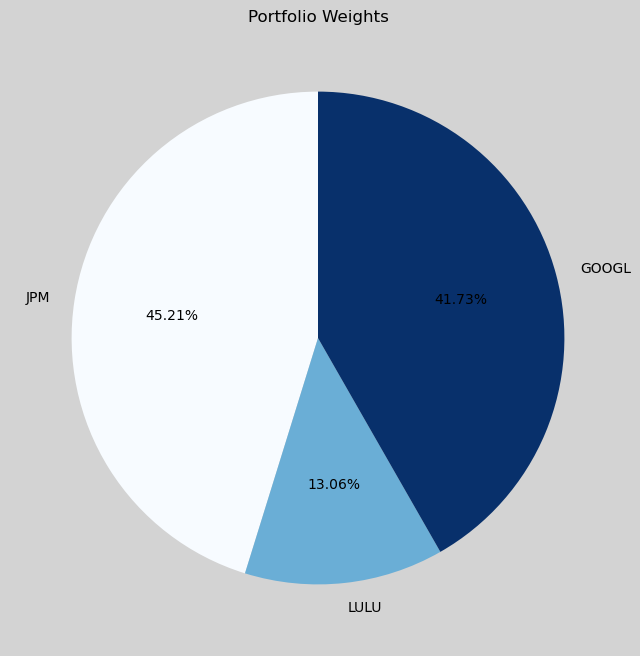

In [11]:
w_sharpe = opt_sharpe(rt_train, rf)
vt.plot_weights(tickers, w_sharpe)

### Liquidity Variance Return Ratio (LVRR)

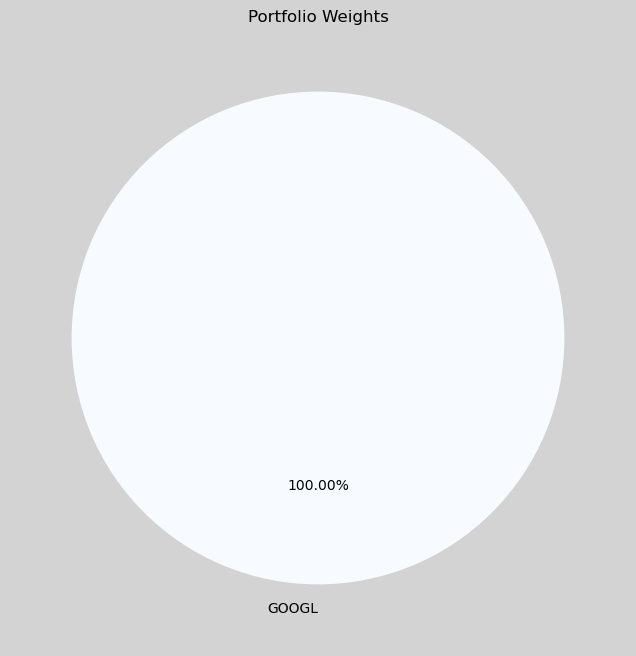

In [12]:
w_lvrr = lvrr(price_train, volume_train, pv, rf)
vt.plot_weights(tickers, w_lvrr)

### Target Semivariance

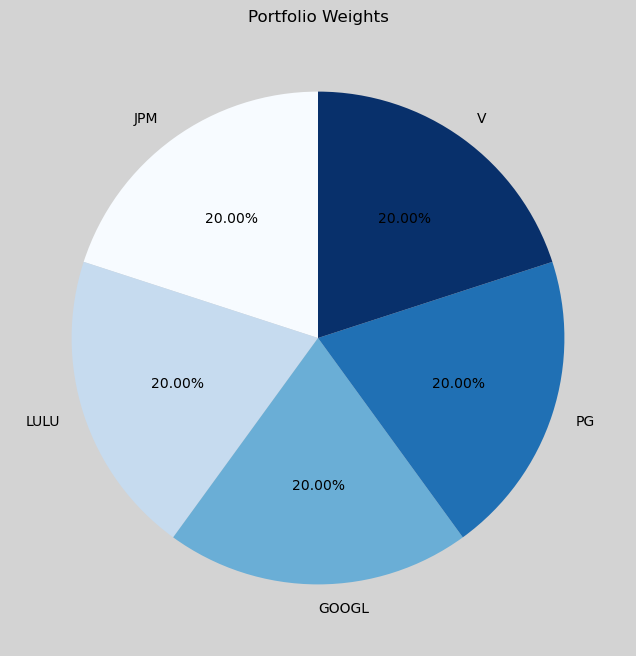

In [13]:
w_semivariance = semivariance(price_train, benchmark_train)
vt.plot_weights(tickers, w_semivariance)

### Omega

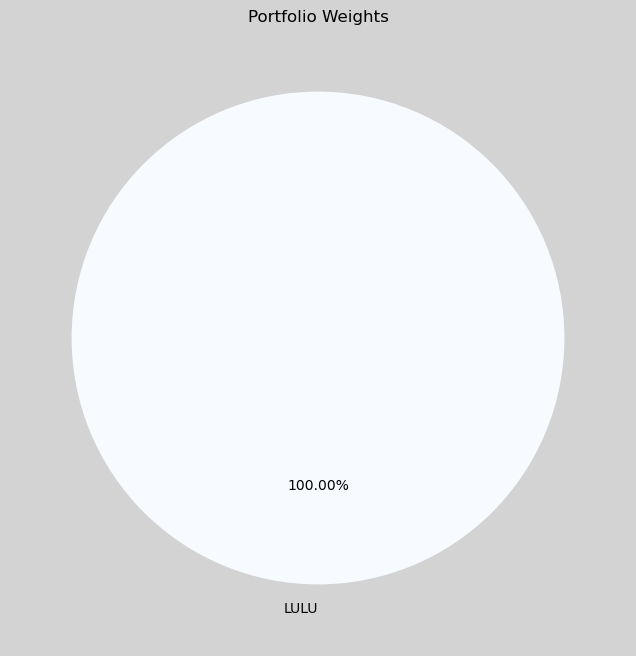

In [14]:
w_omega = omega(price_train, benchmark_train)
vt.plot_weights(tickers, w_omega)

### Gráfica

In [15]:
strats = [w_sharpe, w_lvrr, w_semivariance, w_omega]
strats_returns = [portfolio_return(rt_test, w) for w in strats]

cumulative_returns = [(1 + r).cumprod() for r in strats_returns]
cumulative_money = [pv * cr for cr in cumulative_returns]

cumulative_returns_df = pd.DataFrame(cumulative_returns, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T
cumulative_money_df = pd.DataFrame(cumulative_money, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T

cumulative_benchmark_returns = (1 + rt_benchmark_test).cumprod().squeeze()
cumulative_returns_df['Benchmark'] = cumulative_benchmark_returns.values
cumulative_money_df['Benchmark'] = pv * cumulative_benchmark_returns.values

pd.set_option('display.float_format', '{:.2%}'.format)
df_optimal = pd.DataFrame({
    'Ticker': tickers,
    'Sharpe': w_sharpe,
    'LVRR': w_lvrr,
    'Semivariance': w_semivariance,
    'Omega': w_omega
})
df_optimal.set_index('Ticker', inplace=True)

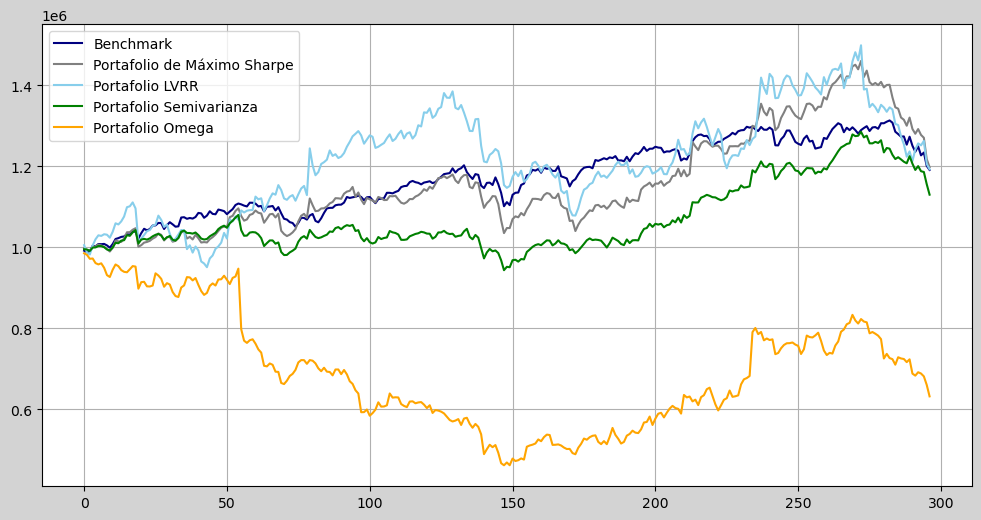

In [16]:
plt.figure(figsize=(12, 6))

plt.plot(cumulative_money_df['Benchmark'], label='Benchmark', c = 'navy')
plt.plot(cumulative_money_df['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'gray')
plt.plot(cumulative_money_df['LVRR'], label='Portafolio LVRR', c = 'skyblue')
plt.plot(cumulative_money_df['Semivariance'], label='Portafolio Semivarianza', c = 'green')
plt.plot(cumulative_money_df['Omega'], label='Portafolio Omega', c = 'orange')

plt.legend()
plt.grid();

In [17]:
print(f'Pesos óptmio de las estrategias')
display(df_optimal.T)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(cumulative_returns_df)

print()

print(f'Evolución del valor del portafolio')
display(cumulative_money_df)

for i in cumulative_money_df.columns:
    print(f'El valor final del portafolio {i} es de {cumulative_money_df[i].iloc[-1]:,.2f}')

Pesos óptmio de las estrategias


Ticker,JPM,LULU,GOOGL,PG,V
Sharpe,45.21%,13.06%,41.73%,0.00%,0.00%
LVRR,0.00%,0.00%,100.00%,0.00%,0.00%
Semivariance,20.00%,20.00%,20.00%,20.00%,20.00%
Omega,0.00%,100.00%,0.00%,0.00%,0.00%



Evolución de los rendimientos


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,0.998393,1.005428,0.995404,0.985437,0.991833
1,0.993272,0.987117,0.994640,0.981440,0.988639
2,0.992237,0.982340,0.991126,0.971744,0.989993
3,1.001174,1.004849,0.999416,0.972496,1.004126
4,1.002409,1.020120,0.999949,0.961079,1.002602
...,...,...,...,...,...
292,1.292164,1.256765,1.200575,0.691618,1.249422
293,1.277719,1.251898,1.188057,0.688472,1.227243
294,1.270691,1.262867,1.186144,0.681388,1.234121
295,1.217948,1.206217,1.156137,0.660434,1.201250



Evolución del valor del portafolio


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,9.983926e+05,1.005428e+06,9.954035e+05,985436.669836,9.918333e+05
1,9.932718e+05,9.871174e+05,9.946401e+05,981439.699252,9.886386e+05
2,9.922375e+05,9.823405e+05,9.911256e+05,971744.036881,9.899926e+05
3,1.001174e+06,1.004849e+06,9.994164e+05,972495.955989,1.004126e+06
4,1.002409e+06,1.020120e+06,9.999487e+05,961078.766002,1.002602e+06
...,...,...,...,...,...
292,1.292164e+06,1.256765e+06,1.200575e+06,691618.179196,1.249422e+06
293,1.277719e+06,1.251898e+06,1.188057e+06,688472.039020,1.227243e+06
294,1.270691e+06,1.262867e+06,1.186144e+06,681388.226729,1.234121e+06
295,1.217948e+06,1.206217e+06,1.156137e+06,660433.704913,1.201250e+06


El valor final del portafolio Sharpe es de 1,198,198.63
El valor final del portafolio LVRR es de 1,192,909.18
El valor final del portafolio Semivariance es de 1,130,134.29
El valor final del portafolio Omega es de 632,039.28
El valor final del portafolio Benchmark es de 1,191,264.07


### Métricas de desempeño

In [18]:
X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [strats_returns[i] for i in range(len(strats_returns))]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

port_ret = np.mean(strats_returns, axis=1) * 252
port_vol = np.std(strats_returns, axis=1) * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))
sortino = 0 #(port_ret - rf) / (returns_df[returns_df < 0].std() * np.sqrt(252))

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary.set_index(pd.Index(['Sharpe', 'LVRR', 'Semivariance', 'Omega']), inplace=True)
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.172083,0.192868,0.632987,1.034886,0.011200,0
LVRR,0.191168,0.287787,0.490528,1.233584,0.008995,0
Semivariance,0.114515,0.146011,0.441850,0.744615,-0.015267,0
Omega,-0.315679,0.381491,-0.958552,1.056931,-0.478924,0


In [19]:
total_return = [cumulative_returns[i][-1] - 1 for i in range(len(cumulative_returns))]
period_years = len(rt_test) / 252
anualized_returns = (np.ones(len(total_return)) + total_return) ** (1 / period_years) - 1
anualized_returns

array([ 0.16581734,  0.16144916,  0.10937926, -0.3224609 ])

In [20]:
vt.var_weights(price_test, w_sharpe, 99), vt.cvar_weights(price_test, w_sharpe, 99)

(0.03643569883110356, 0.04132436159323556)

In [21]:
vt.var_weights(price_test, w_lvrr, 99), vt.cvar_weights(price_test, w_lvrr, 99)

(0.04756603035324428, 0.06610497890086121)

In [22]:
vt.var_weights(price_test, w_semivariance, 99), vt.cvar_weights(price_test, w_semivariance, 99)

(0.026126017625689175, 0.03232272127487895)

In [23]:
vt.var_weights(price_test, w_omega, 99), vt.cvar_weights(price_test, w_omega, 99)

(0.06225784982402766, 0.10707241901974807)